In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [15]:
data = pd.read_csv('C:/Users/ocar5/OneDrive/Documents/Codes/Python/MNIST/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [4]:
Y_train

array([3, 9, 0, ..., 7, 4, 6], shape=(41000,))

In [ ]:
# Parámetros del modelo
neu_entrada = 784  # Número de neuronas en la capa de entrada (corresponde a las características de los datos).
neu_oculta = 25   # Número de neuronas en la capa oculta de la red neuronal. Este es un hiperparámetro a ajustar.
neu_salida = 10   # Número de neuronas en la capa de salida (corresponde al número de clases).

# Parámetros genéticos
poblacion = 100     # Tamaño de la población de soluciones candidatas (redes neuronales) en cada generación.
generaciones = 1000  # Número total de generaciones que el algoritmo genético ejecutará.
prob_mutacion = 0.1  # Probabilidad de que un gen (peso) individual sufra una mutación.

# Cálculo del tamaño total del vector
def calculo_tam_vector():
    # Calcula la longitud del vector que representa una red neuronal completa (pesos y sesgos).
    return neu_oculta * neu_entrada + neu_oculta + neu_salida * neu_oculta + neu_salida

tam_vector = calculo_tam_vector()  # Almacena el tamaño del vector calculado.

# Codificar pesos y sesgos
def encode_weights(W1, b1, W2, b2):
    # Toma las matrices de pesos (W1, W2) y los vectores de sesgos (b1, b2) de la red neuronal
    # y los aplana para concatenarlos en un único vector unidimensional que representa al individuo.
    return np.concatenate([W1.flatten(), b1.flatten(), W2.flatten(), b2.flatten()])

# Decodificar pesos y sesgos
def deco_pesos(vector):
    # Toma un vector unidimensional y lo reshapea para obtener las matrices de pesos y los vectores de sesgos
    # de la red neuronal, utilizando las dimensiones predefinidas.
    i = 0
    W1 = vector[i:i + neu_oculta * neu_entrada].reshape((neu_oculta, neu_entrada))
    i += neu_oculta * neu_entrada
    b1 = vector[i:i + neu_oculta].reshape((neu_oculta, 1))
    i += neu_oculta
    W2 = vector[i:i + neu_salida * neu_oculta].reshape((neu_salida, neu_oculta))
    i += neu_salida * neu_oculta
    b2 = vector[i:i + neu_salida].reshape((neu_salida, 1))
    return W1, b1, W2, b2

# Inicializar población
def ini_poblacion():
    # Crea una población inicial de individuos (vectores que representan redes neuronales)
    # con valores aleatorios distribuidos uniformemente entre -1 y 1.
    return [np.random.uniform(-1, 1, tam_vector) for _ in range(poblacion)]

# Funciones de activación
def ReLU(Z):
    # Implementación de la función de activación ReLU (Rectified Linear Unit), que devuelve max(0, Z).
    return np.maximum(0, Z)

def softmax(Z):
    # Implementación de la función de activación Softmax, utilizada en la capa de salida para obtener
    # probabilidades normalizadas para cada clase. Se incluye una resta del máximo para estabilidad numérica.
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

# Propagación hacia adelante
def forward_prop(X, W1, b1, W2, b2):
    # Realiza la propagación hacia adelante a través de la red neuronal, calculando las salidas de cada capa.
    Z1 = W1 @ X + b1  # Cálculo de la entrada a la capa oculta.
    A1 = ReLU(Z1)     # Aplicación de la función de activación ReLU en la capa oculta.
    Z2 = W2 @ A1 + b2  # Cálculo de la entrada a la capa de salida.
    A2 = softmax(Z2)    # Aplicación de la función de activación Softmax en la capa de salida.
    return A2

# Evaluación de aptitud
def eva_fitness(individual, X, Y):
    # Evalúa la aptitud de un individuo (red neuronal) calculando su exactitud en el conjunto de datos (X, Y).
    W1, b1, W2, b2 = deco_pesos(individual)  # Decodifica el vector para obtener los pesos y sesgos.
    A2 = forward_prop(X, W1, b1, W2, b2)     # Realiza la propagación hacia adelante para obtener las predicciones.
    predictions = np.argmax(A2, axis=0)      # Obtiene la clase predicha con la mayor probabilidad.
    return np.mean(predictions == Y)        # Calcula la exactitud comparando las predicciones con las etiquetas verdaderas.

# Cruce de un punto
def cruce(padre1, padre2):
    # Implementa el operador de cruce de un punto. Se elige un punto aleatorio a lo largo del vector
    # y se intercambian las secciones de los dos padres para crear dos nuevos hijos.
    point = np.random.randint(1, tam_vector - 1)  # Elige un punto de cruce aleatorio.
    hijo1 = np.concatenate([padre1[:point], padre2[point:]])  # Crea el primer hijo combinando la primera parte del padre1 y la segunda del padre2.
    hijo2 = np.concatenate([padre2[:point], padre1[point:]])  # Crea el segundo hijo combinando la primera parte del padre2 y la segunda del padre1.
    return hijo1, hijo2

# Mutación suave
def mutar(individual):
    # Implementa un operador de mutación suave. Para cada gen (peso) en el individuo,
    # existe una probabilidad de `prob_mutacion` de añadirle un pequeño valor aleatorio tomado de una distribución normal.
    for i in range(tam_vector):
        if np.random.rand() < prob_mutacion:
            individual[i] += np.random.normal(0, 0.1)  # Añade una pequeña mutación aleatoria.
    return individual

# Algoritmo genético principal
def algoritmo_genetico(X, Y):
    # Implementa el algoritmo genético principal.
    pobla = ini_poblacion()  # Inicializa la población.
    elites = 5               # Número de los mejores individuos que se conservan directamente en la siguiente generación (elitismo).
    lista_hist = []          # Lista para almacenar la exactitud de cada individuo en cada generación.

    for generacion in range(generaciones):
        # Evalúa la aptitud de cada individuo en la población actual.
        puntajes = [eva_fitness(ind, X, Y) for ind in pobla]
        lista_hist.append(puntajes)  # Guarda los puntajes de la generación actual.
        # Ordena la población basándose en su aptitud (de mayor a menor).
        pocision = [x for _, x in sorted(zip(puntajes, pobla), key=lambda pair: pair[0], reverse=True)]

        # Imprime la mejor exactitud alcanzada en la generación actual.
        print(f"Generación {generacion} - Mejor Exactitud: {max(puntajes):.4f}")

        elite = pocision[:elites]  # Selecciona a los `elites` mejores individuos.
        hijos = []                 # Lista para almacenar los nuevos individuos (hijos).

        # Genera nuevos individuos hasta alcanzar el tamaño de la población deseado.
        while len(elite) + len(hijos) < poblacion:
            # Selecciona dos padres aleatoriamente del top 20 de la población ordenada.
            indice_padres = np.random.choice(20, 2, replace=False)
            padre1 = pocision[indice_padres[0]]
            padre2 = pocision[indice_padres[1]]
            # Aplica el operador de cruce para generar dos hijos.
            hijo1, hijo2 = cruce(padre1, padre2)
            # Aplica la mutación a los hijos y los añade a la lista de hijos.
            hijos.append(mutar(hijo1))
            if len(elite) + len(hijos) < poblacion:
                hijos.append(mutar(hijo2))

        # Crea la nueva población combinando los individuos de élite con los nuevos hijos.
        pobla = elite + hijos

    # Encuentra al mejor individuo de la última generación.
    mejor_solo = max(pobla, key=lambda ind: eva_fitness(ind, X, Y))
    return mejor_solo, lista_hist

# Ejecutar algoritmo genético y evaluar en validación
# (Asumo que X_train, Y_train, X_dev, Y_dev ya están definidos y cargados)
# Ejemplo de cómo podrías cargar datos (necesitarías adaptar esto a tu caso):
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_digits
# digits = load_digits()
# X = digits.data.T / 255.0
# Y = digits.target
# Y_one_hot = np.eye(10)[Y]
# X_train, X_dev, Y_train, Y_dev_one_hot, Y_dev = train_test_split(X.T, Y_one_hot, Y, test_size=0.2, random_state=42)
# X_train = X_train.T
# X_dev = X_dev.T
# Y_train = Y_train.flatten()
# Y_dev = Y_dev.flatten()

mejores_pesos, lista_hist = algoritmo_genetico(X_train, Y_train)

# Decodificar mejores pesos
W1, b1, W2, b2 = deco_pesos(mejores_pesos)

# Evaluación en conjunto de validación
A2 = forward_prop(X_dev, W1, b1, W2, b2)
predictions = np.argmax(A2, axis=0)
exact_eva = np.mean(predictions == Y_dev)
print(f"Exactitud en conjunto de validación: {exact_eva:.4f}")

Generación 0 - Mejor Exactitud: 0.1930
Exactitud en conjunto de validación: 0.1750


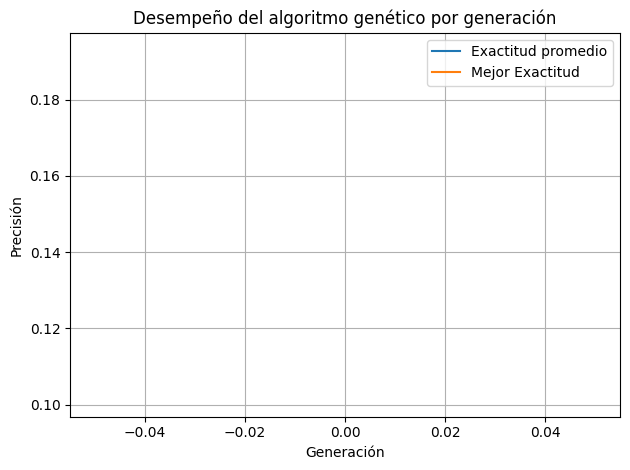

In [14]:
# Visualización de precisión por generación
prom_exactitud = [np.mean(g) for g in lista_hist]
mejor_exactitud = [np.max(g) for g in lista_hist]

plt.plot(prom_exactitud, label='Exactitud promedio')
plt.plot(mejor_exactitud, label='Mejor Exactitud')
plt.xlabel("Generación")
plt.ylabel("Precisión")
plt.title("Desempeño del algoritmo genético por generación")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()